# Spoken Language Recognition Using Convolutional Neural Networks

_written by Joscha S. Rieber (Fraunhofer IAIS) in 2020_

## Training Environment

In [2]:
train = 'train'
test = 'test'

eng = 'english'
ger = 'german'

languages = [eng, ger]
categories = [train, test]

dataset_root_path = '../data/'
train_path = dataset_root_path + train

batch_size = 128
image_width = 500
image_height = 128

validation_split = 0.1
initial_learning_rate = 0.045

num_classes = len(languages)

model_file = dataset_root_path + 'model.h5'

In [3]:
from glob import glob
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [4]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per Epoch: 450
Validation steps: 50


## Training Batch Generator Function

The following function loads the available images for training, shuffles them and serves them to Keras' training algorithm.

In [5]:
image_data_generator = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')

Found 57600 images belonging to 2 classes.
Found 6400 images belonging to 2 classes.


## Model definition

In [6]:
img_input = Input(shape=(image_height, image_width, 1))

img_conc = Concatenate(axis=3, name='input_concat')([img_input, img_input, img_input])

model = InceptionV3(input_tensor=img_conc, weights=None, include_top=True, classes=2)

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 500, 1) 0                                            
__________________________________________________________________________________________________
input_concat (Concatenate)      (None, 128, 500, 3)  0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 249, 32)  864         input_concat[0][0]               
_______________________________________________________________________________________

In [7]:
model.compile(optimizer=RMSprop(lr=initial_learning_rate, clipvalue=2.0), loss='categorical_crossentropy', metrics=['accuracy'])

## Training

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

In [9]:
def step_decay(epoch, lr):
    drop = 0.94
    epochs_drop = 2.0
    lrate = lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

learning_rate_decay = LearningRateScheduler(step_decay, verbose=1)

In [10]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=60, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping, learning_rate_decay])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.04500000178813934.
Epoch 1/60
450/450 [==============================] - 438s 973ms/step - loss: 0.8975 - accuracy: 0.6056 - val_loss: 3474.6665 - val_accuracy: 0.5005 - lr: 0.0450

Epoch 00002: LearningRateScheduler reducing learning rate to 0.042300001680850983.
Epoch 2/60
450/450 [==============================] - 435s 968ms/step - loss: 0.4109 - accuracy: 0.8289 - val_loss: 1.5838 - val_accuracy: 0.6755 - lr: 0.0423

Epoch 00003: LearningRateScheduler reducing learning rate to 0.03976200073957443.
Epoch 3/60
450/450 [==============================] - 436s 968ms/step - loss: 0.2622 - accuracy: 0.8920 - val_loss: 0.6689 - val_accuracy: 0.7358 - lr: 0.0398

Epoch 00004: LearningRateScheduler reducing learning rate to 0.03513370451182127.
Epoch 4/60
450/450 [==============================] - 436s 969ms/step - loss: 0.1976 - accuracy: 0.9214 - val_loss: 0.8902 - val_accuracy: 0.7627 - lr: 0.0351

Epoch 00005: LearningRateSc

In [11]:
model.save(model_file)

## Plot Training History for Accuracy

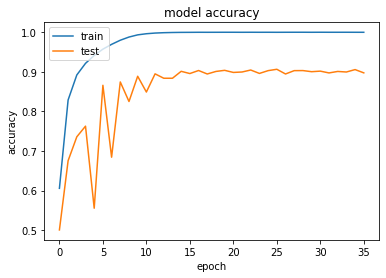

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Model Evaluation Environment


The following function loads the available images for evaluation

In [13]:
test_path = dataset_root_path + test

In [14]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))

Evaluation steps: 62


In [15]:
image_data_generator = ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale')

Found 8000 images belonging to 2 classes.


## Model Evaluation

In [16]:
from tensorflow.keras.models import load_model

In [17]:
model = load_model(model_file)

In [18]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)

62/62 [==============================] - 28s 452ms/step - loss: 0.6730 - accuracy: 0.9376


In [19]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')

Test accuracy: 93.8 %
